In [1]:
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.backends.backend_pdf as pdf
matplotlib.rcParams['pdf.fonttype'] = 42
matplotlib.rcParams['ps.fonttype'] = 42

import numpy as np
import pandas as pd
import colors as EL
import math, os
import more_itertools as mit

In [2]:
N = 120

In [3]:
df = pd.read_csv("./data/experiment_IDs/cleaned_static_data.csv")
df = df[df['dead'] != 'Yes']
master_df = pd.DataFrame()

for index, row in df.iterrows():
    animal = row["animal_ID"]
    species = row['species']
    date = animal.split('-')[0]
    pos = animal.split('-')[-1]
    num = animal.split('-')[1]
    readname = "./data/trajectories/video_calculations/"+\
            date+"-"+num+"-E-"+pos+".csv"
    try:
        temp = pd.read_csv(readname)
        temp["animal_ID"] = animal
        temp['species'] = species
        temp["treatment_odor"] = row["treatment_odor"]
        master_df = pd.concat([master_df, temp], sort=False)
    except:
        print(readname)
    
master_df.drop(["interpolated", "manual_tracker_fix", "objid", 
                "pixel_height", "pixel_width",
                "measurement_x", "measurement_y", "position_x", 
                "position_y", "bin_ID", 
                "turn", "larvae_length_mm", 
                "pos_x_mm", "pos_y_mm"],
                axis=1, inplace=True)
master_df.to_csv("./data/trajectories/summary_all_animals.csv", index=None)

print(df.species.unique())

for species in df.species.unique():
    temp = master_df[master_df['species'] == species]
    temp.to_csv("./data/trajectories/summary_"+species.replace(' ', '_')+".csv", 
               index=None)

os.remove("./data/trajectories/summary_all_animals.csv")
print("--- All files finished ---")

['Aedes aegypti' 'Aedes albopictus' 'Anopheles arabiensis'
 'Anopheles gambiae' 'Culex quinquefasciatus' 'Culex tarsalis']
--- All files finished ---


In [4]:
def get_angs(species):
    angle_df = pd.read_csv("./data/trajectories/summary_"+\
                           species.replace(' ', '_')+".csv")
    angle_df = angle_df[angle_df["speed_mm_s"] >= 1]
    # display(angle_df.describe())
    
    f_ang = angle_df[angle_df["treatment_odor"] == "05_percent_food"]
    q_ang = angle_df[angle_df["treatment_odor"] == "100ul_quinine"]
    w_ang = angle_df[angle_df["treatment_odor"] == "100ul_milliQ_water"]

    print(f_ang["animal_ID"].nunique(), 
          q_ang["animal_ID"].nunique(), w_ang["animal_ID"].nunique())

    f_angd = [x for x in f_ang["angle_delta"].values if ~np.isnan(x)]
    q_angd = [x for x in q_ang["angle_delta"].values if ~np.isnan(x)]
    w_angd = [x for x in w_ang["angle_delta"].values if ~np.isnan(x)]

    f_ang = f_ang["angle_counterclock"].values
    q_ang = q_ang["angle_counterclock"].values
    w_ang = w_ang["angle_counterclock"].values

    f_ang = [360+x if x<0 else x for x in f_ang]
    q_ang = [360+x if x<0 else x for x in q_ang]
    w_ang = [360+x if x<0 else x for x in w_ang]

    return f_ang, q_ang, w_ang, f_angd, q_angd, w_angd

def get_radii(f_ang, q_ang, w_ang, N):
    f_radii = []
    for ang in range(0, N):
        min_a = (360 / N) * ang
        max_a = (360 / N) * (ang+1)
        temp = [i for i in f_ang if i <= max_a]
        temp = [i for i in temp if i > min_a]
        f_radii.append(len(temp))

    q_radii = []
    for ang in range(0, N):
        min_a = (360 / N) * ang
        max_a = (360 / N) * (ang+1)
        temp = [i for i in q_ang if i <= max_a]
        temp = [i for i in temp if i > min_a]
        q_radii.append(len(temp))

    w_radii = []
    for ang in range(0, N):
        min_a = (360 / N) * ang
        max_a = (360 / N) * (ang+1)
        temp = [i for i in w_ang if i <= max_a]
        temp = [i for i in temp if i > min_a]
        w_radii.append(len(temp))

    # Normalize all frequencies to max 
    w_radii = [x/max(w_radii) for x in w_radii]
    f_radii = [x/max(f_radii) for x in f_radii]
    q_radii = [x/max(q_radii) for x in q_radii]
    theta = np.arange(0.0, 2*np.pi, 2*np.pi/N)
    width = np.radians(360 / N)

    return w_radii, f_radii, q_radii, theta, width

def get_figure(f_ang, q_ang, w_ang, f_angd, q_angd, w_angd,
               w_radii, f_radii, q_radii, theta, width, labels=False):
    fig = plt.figure(figsize=(3, 6))
    ax3 = fig.add_subplot(211, polar="True")
    ax4 = fig.add_subplot(212)

    ax3.bar(theta, f_radii, width=width, bottom=0.0,  clip_on=False,
            lw=0, edgecolor="#ffffff", color=EL.c_food, alpha=0.5, label="Food")
    ax3.bar(theta, q_radii, width=width, bottom=0.0,  clip_on=False,
            lw=0, edgecolor="#ffffff", color=EL.c_quinine, alpha=0.5, label="Quinine")
    ax3.bar(theta, w_radii, width=width, bottom=0.0,  clip_on=False,
            lw=0, edgecolor="#ffffff", color=EL.c_water, alpha=0.5, label="Water")
    ax3.set_thetagrids(np.arange(0, 360, 45))
    ax3.grid(linewidth=1, alpha=0.25, color="k")
    ax3.set_theta_zero_location('E')
    ax3.set_yticklabels([])

    ######### PLOT ANGLE DELTA DISTRIBUTION, FOOD, QUININE, WATER ############
    bins = np.linspace(-180, 180, 50)
    ax4.hist(f_angd, bins=bins, color=EL.c_food, normed=True, clip_on=False,
             alpha=0.5, lw=0, edgecolor="#ffffff", label="Food")
    ax4.hist(q_angd, bins=bins, color=EL.c_quinine, normed=True,  clip_on=False,
             alpha=0.5, lw=0, edgecolor="#ffffff", label="Quinine")
    ax4.hist(w_angd, bins=bins, color=EL.c_water, normed=True,  clip_on=False,
             alpha=0.5, lw=0, edgecolor="#ffffff", label="Water")
    ax4.set_xticks([-180, -90, 0, 90, 180])
    ax4.set_xticks(np.arange(-180, 180, 30), minor=True)
    ax4.set_xlim(-180, 180)
    ax4.spines['right'].set_visible(False)
    ax4.spines['top'].set_visible(False)
    
    ax4.set_ylim(0, 0.03)
    ax3.set_xticklabels([])
    if labels == True:
        ax4.set_yticks(np.arange(0, 0.04, 0.01))
        ax4.legend(frameon=False, loc='lower right', handletextpad=0.5, 
              bbox_to_anchor=(-0.095, 0, 1.05, 1.175), ncol=3, columnspacing=0.55)
    else: 
        ax4.set_yticks([])
        ax4.spines['left'].set_visible(False)

    return fig, ax3, ax4

def save_figure(fig, savename):
    # Save the Matplotlib figure as a PDF file:
    pp = pdf.PdfPages(savename, keep_empty=False)
    pp.savefig(fig)
    pp.close()
    # Show the figure
    plt.show() 

20 25 24


/Users/ghost/anaconda3/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6521: MatplotlibDeprecationWarning: 
The 'normed' kwarg was deprecated in Matplotlib 2.1 and will be removed in 3.1. Use 'density' instead.
  alternative="'density'", removal="3.1")


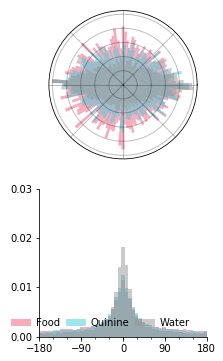

In [5]:
species = 'Aedes aegypti'
savename = './figures/angular/aegypti.pdf'

f_ang, q_ang, w_ang, f_angd, q_angd, w_angd = get_angs(species)
w_radii, f_radii, q_radii, theta, width = get_radii(f_ang, q_ang, w_ang, N)
fig, ax3, ax4 = get_figure(f_ang, q_ang, w_ang, f_angd, q_angd, w_angd,
               w_radii, f_radii, q_radii, theta, width, 
                           labels=True)

save_figure(fig, savename)

22 26 23


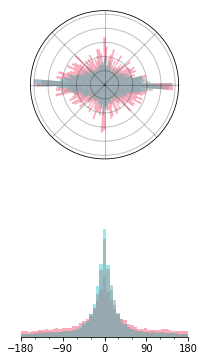

In [6]:
species = 'Aedes albopictus'
savename = './figures/angular/albopictus.pdf'

f_ang, q_ang, w_ang, f_angd, q_angd, w_angd = get_angs(species)
w_radii, f_radii, q_radii, theta, width = get_radii(f_ang, q_ang, w_ang, N)
fig, ax3, ax4 = get_figure(f_ang, q_ang, w_ang, f_angd, q_angd, w_angd,
               w_radii, f_radii, q_radii, theta, width)

save_figure(fig, savename)

27 32 26


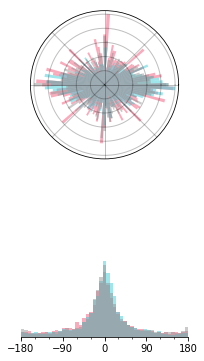

In [7]:
species = 'Anopheles arabiensis'
savename = './figures/angular/arabiensis.pdf'

f_ang, q_ang, w_ang, f_angd, q_angd, w_angd = get_angs(species)
w_radii, f_radii, q_radii, theta, width = get_radii(f_ang, q_ang, w_ang, N)
fig, ax3, ax4 = get_figure(f_ang, q_ang, w_ang, f_angd, q_angd, w_angd,
               w_radii, f_radii, q_radii, theta, width)

save_figure(fig, savename)

32 37 34


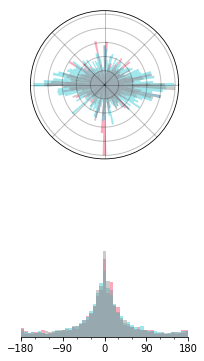

In [8]:
species = 'Anopheles gambiae'
savename = './figures/angular/gambiae.pdf'

f_ang, q_ang, w_ang, f_angd, q_angd, w_angd = get_angs(species)
w_radii, f_radii, q_radii, theta, width = get_radii(f_ang, q_ang, w_ang, N)
fig, ax3, ax4 = get_figure(f_ang, q_ang, w_ang, f_angd, q_angd, w_angd,
               w_radii, f_radii, q_radii, theta, width)

save_figure(fig, savename)

33 40 36


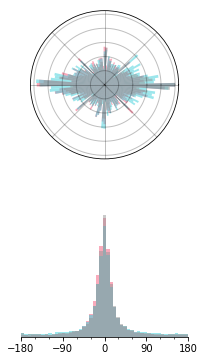

In [9]:
species = 'Culex quinquefasciatus'
savename = './figures/angular/quinquefasciatus.pdf'

f_ang, q_ang, w_ang, f_angd, q_angd, w_angd = get_angs(species)
w_radii, f_radii, q_radii, theta, width = get_radii(f_ang, q_ang, w_ang, N)
fig, ax3, ax4 = get_figure(f_ang, q_ang, w_ang, f_angd, q_angd, w_angd,
               w_radii, f_radii, q_radii, theta, width)

save_figure(fig, savename)

20 15 18


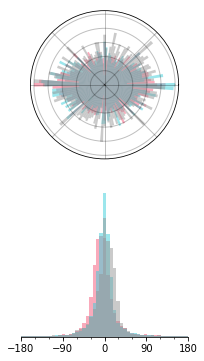

In [10]:
species = 'Culex tarsalis'
savename = './figures/angular/tarsalis.pdf'

f_ang, q_ang, w_ang, f_angd, q_angd, w_angd = get_angs(species)
w_radii, f_radii, q_radii, theta, width = get_radii(f_ang, q_ang, w_ang, N)
fig, ax3, ax4 = get_figure(f_ang, q_ang, w_ang, f_angd, q_angd, w_angd,
               w_radii, f_radii, q_radii, theta, width)

save_figure(fig, savename)